# Observing Hardy-type nonlocality on IBM_Brisbane
- This notebook responsibles for practical datas obtained from IBM Brisbane, which are used later in Figure 6, 7, and 8 in the paper.
- This notebook is executed when Qiskit is in version 2.0.0.
- Due to the limited time available for backend usage, all circuits in this experiment were only executed with 2048 shots.

In [1]:
import pandas as pd

In [2]:
import qiskit
qiskit.__version__

'2.0.0'

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr
import numpy as np

# 1. First set of conditions
## a) Quantum circuit

In [4]:
def first_condition_circuit(num_qubit, theta):
    num_ancilla = num_qubit
    q = QuantumRegister(num_qubit)
    anc = QuantumRegister(num_ancilla, name="anc")
    qc = QuantumCircuit(q,anc)
    
    for i in range (num_qubit):
        qc.ry(theta,i)
    
    qc.barrier()
    for i in range(num_qubit):
        if i == num_qubit-1:
            qc.ccx(q[i-3],q[i],anc[num_qubit-1])
        else:
            qc.ccx(q[i],q[i+1],anc[i])
    qc.barrier()
    qc.measure_all()
    
    return qc

In [5]:
pi = np.pi

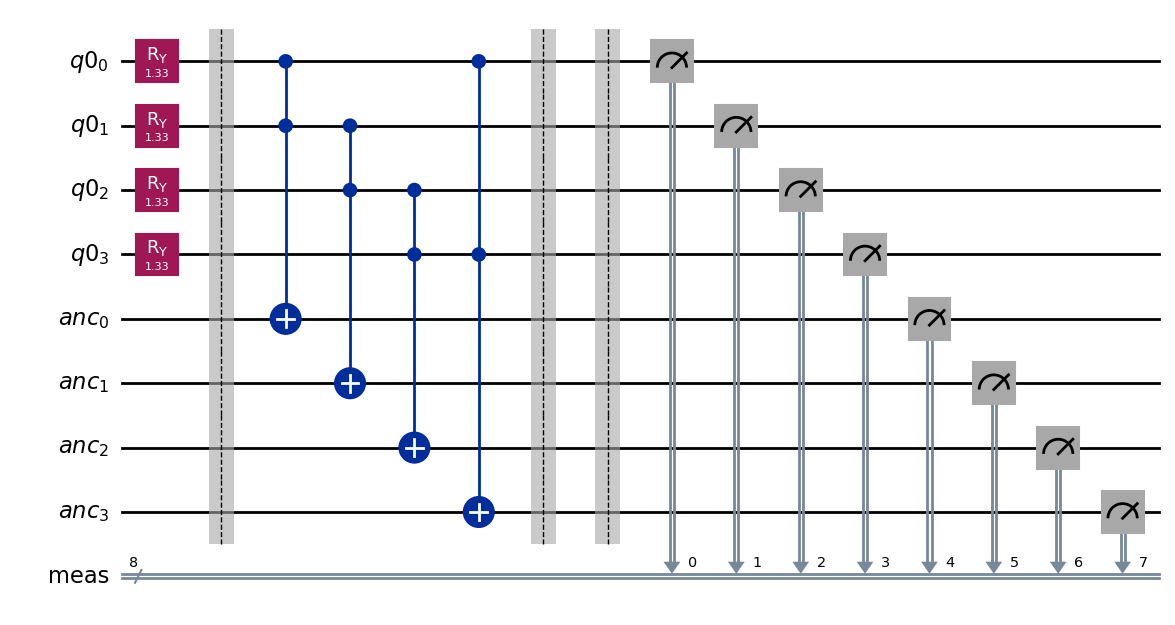

In [6]:
qc = first_condition_circuit(4,0.423*pi)
qc.draw(output='mpl')

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.compiler import transpile

In [8]:
service = QiskitRuntimeService()
backend = service.backend(name='ibm_brisbane')

C:\Users\DELL\AppData\Local\Temp\ipykernel_20240\1056856414.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


In [9]:
qc_transpiled = transpile(qc, backend=backend)

In [10]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)

In [82]:
job = sampler.run(circuits, shots=1024*2)
print(job.job_id())

d0cy8xkd8drg008zaw30


In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [83]:
job_id = 'd0cy8xkd8drg008zaw30'
service = QiskitRuntimeService()
job = service.job(job_id)

C:\Users\DELL\AppData\Local\Temp\ipykernel_14396\1240663657.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


## b) Raw data from Brisbane

In [84]:
result1 = job.result()

In [86]:
sampler_result_cond1 = result1[0]

In [87]:
data = sampler_result_cond1.data

In [89]:
counts = data.meas.get_counts()
d = 0
for n in range (4):
    for k, v in list(counts.items()):
        j = 0
        for p in range (1):
            if len(k) > 0 and k[0] == '1':
                d += v
                del counts[k]
                break
            j+=1

    for k, v in list(counts.items()):
        counts[k[1:]] = counts.pop(k)
        
counts = {state[::-1]: population for state, population in counts.items()}

## c) Final result (converted to probability)

In [96]:
df1 = pd.DataFrame(list(counts.items()), columns=["States", "Counts"])

In [97]:
df1.to_excel("cond1_Brisbane_data.xlsx", index=False)

In [2]:
experiment1 = pd.read_excel("cond1_Brisbane_data.xlsx", dtype={"States": str})
counts = dict(zip(experiment1["States"], experiment1["Counts"]))

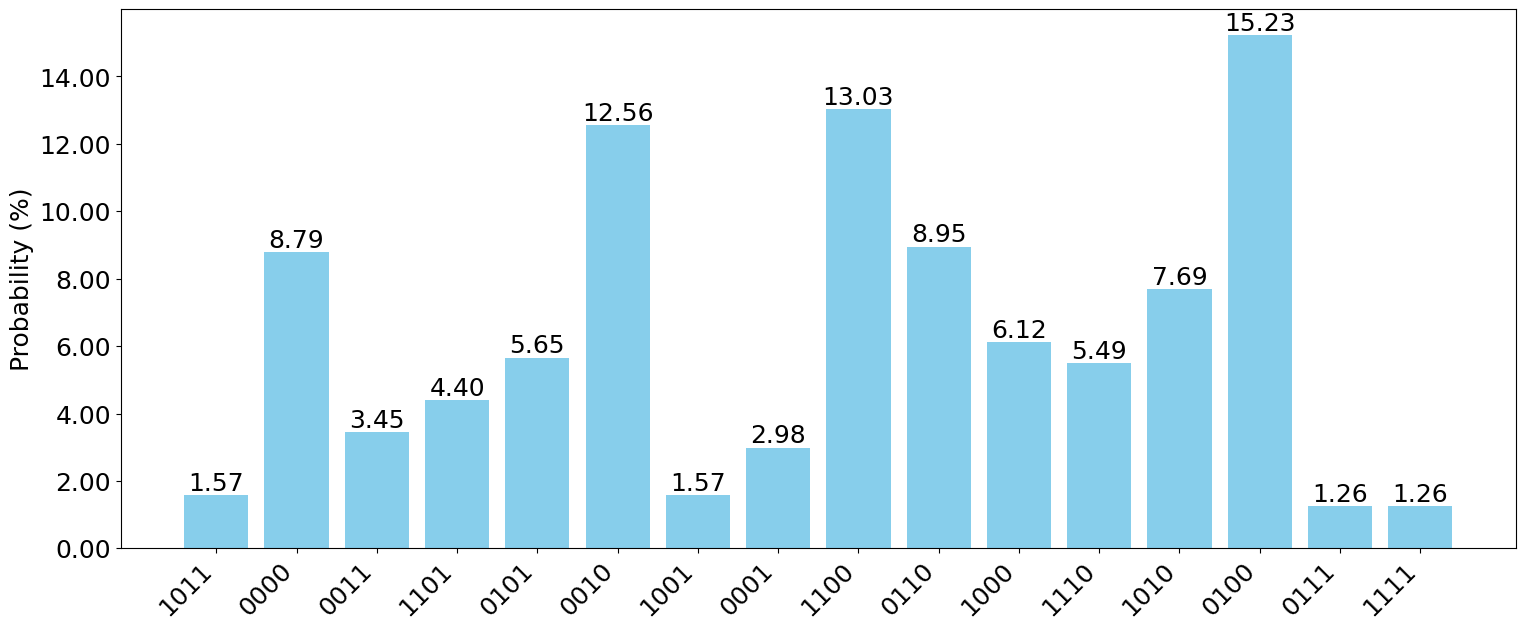

In [5]:
from matplotlib.ticker import FuncFormatter
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
total_count = sum(counts.values())

probabilities = {state: count / total_count for state, count in counts.items()}

states = list(probabilities.keys())  
prob_values = list(probabilities.values())

plt.figure(figsize=(18, 7))
bars = plt.bar(states, prob_values, color='skyblue')

for bar, prob in zip(bars, prob_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
              f'{prob * 100:.2f}', ha='center', va='bottom', fontsize=18)

def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability (%)", fontsize=18)

plt.show()

# 2. Second set of conditions
## 2.1. $R_y(-\theta)$ on the first qubit
### a) Quantum circuit

In [67]:
def second_condition_circuit(num_qubit, k, theta):
    num_ancilla = num_qubit
    q = QuantumRegister(num_qubit)
    anc = QuantumRegister(num_ancilla, name="anc")
    #c = ClassicalRegister(num_qubit + num_ancilla, name="c")
    qc = QuantumCircuit(q,anc)
    
    for i in range (num_qubit):
        qc.ry(theta,i)
    
    qc.barrier()
    for i in range(num_qubit):
        if i == num_qubit-1:
            qc.ccx(q[i-3],q[i],anc[num_qubit-1])
        else:
            qc.ccx(q[i],q[i+1],anc[i])
    qc.barrier()
    qc.ry(-theta,q[k])
    qc.barrier()
    qc.measure_all()
    
    return qc

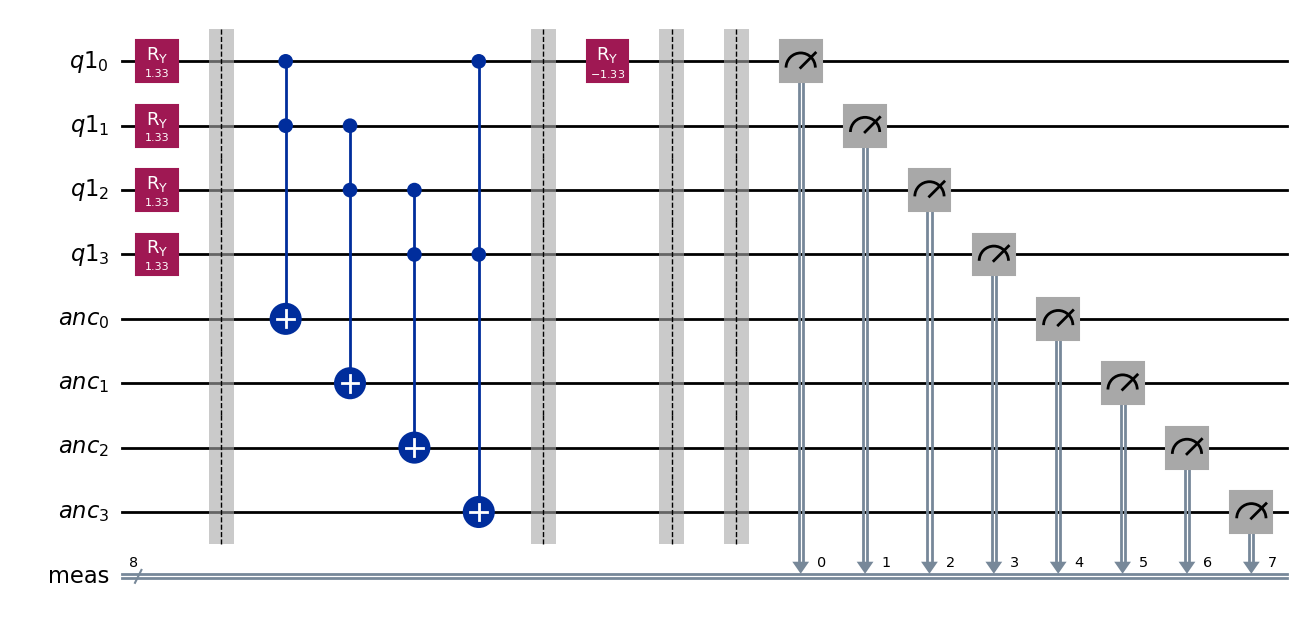

In [68]:
qc21 = second_condition_circuit(4,0,0.423*pi)
qc21.draw(output='mpl')

In [69]:
qc21_transpiled = transpile(qc21, backend=backend)
job21 = sampler.run([qc21_transpiled], shots=1024*2)
print(job21.job_id())

In [129]:
job_id = 'd051ch2qnmvg0084hbcg'
job21 = service.job(job_id)

### b) Raw data

In [130]:
result21 = job21.result()
sampler_result21 = result21[0]
data21 = sampler_result21.data
counts21 = data21.meas.get_counts()
d = 0
for n in range (4):
    for k, v in list(counts21.items()):
        j = 0
        for p in range (1):
            if len(k) > 0 and k[0] == '1':
                d += v
                del counts21[k]
                break
            j+=1

    for k, v in list(counts21.items()):
        counts21[k[1:]] = counts21.pop(k)
        
counts21 = {state[::-1]: population for state, population in counts21.items()}

### c) Final result

In [103]:
df2 = pd.DataFrame(list(counts21.items()), columns=["States", "Counts"])
df2.to_excel("cond21_Brisbane_data.xlsx", index=False)

In [6]:
experiment21 = pd.read_excel("cond21_Brisbane_data.xlsx", dtype={"States": str})
counts21 = dict(zip(experiment21["States"], experiment21["Counts"]))

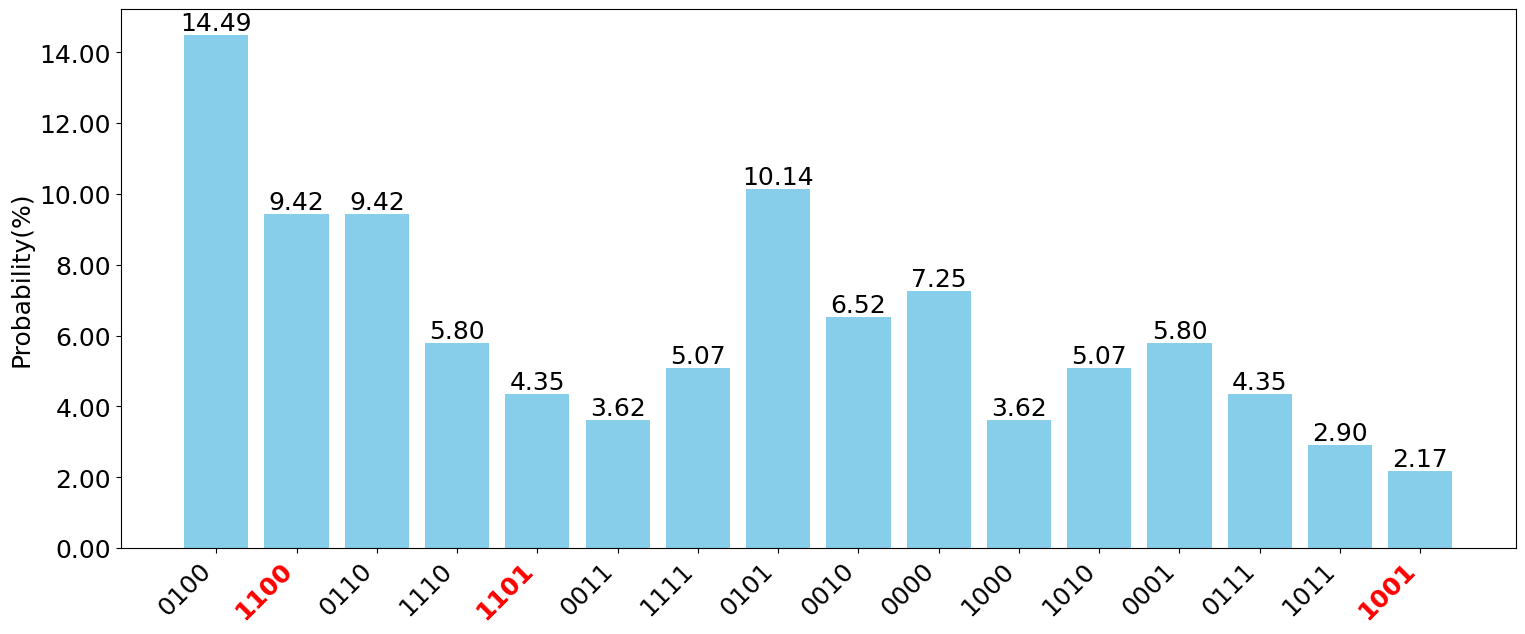

In [7]:
total_count = sum(counts21.values())

probabilities = {state: count / total_count for state, count in counts21.items()}

states = list(probabilities.keys())  
prob_values = list(probabilities.values())

plt.figure(figsize=(18, 7))
bars = plt.bar(states, prob_values, color='skyblue')

for bar, prob in zip(bars, prob_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
              f'{prob * 100:.2f}', ha='center', va='bottom', fontsize=18)

highlight_states = {'1001', '1101', '1100'}  
tick_labels = plt.gca().get_xticklabels()  
tick_labels_text = plt.gca().get_xticklabels() 
for label, state in zip(tick_labels_text, states):  
    if state in highlight_states:
        label.set_color('red')  
        label.set_fontweight('bold')  
        
def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability(%)", fontsize=18)

plt.show()

## 2.2. $R_y(-\theta)$ on the second qubit
### a) Quantum circuit

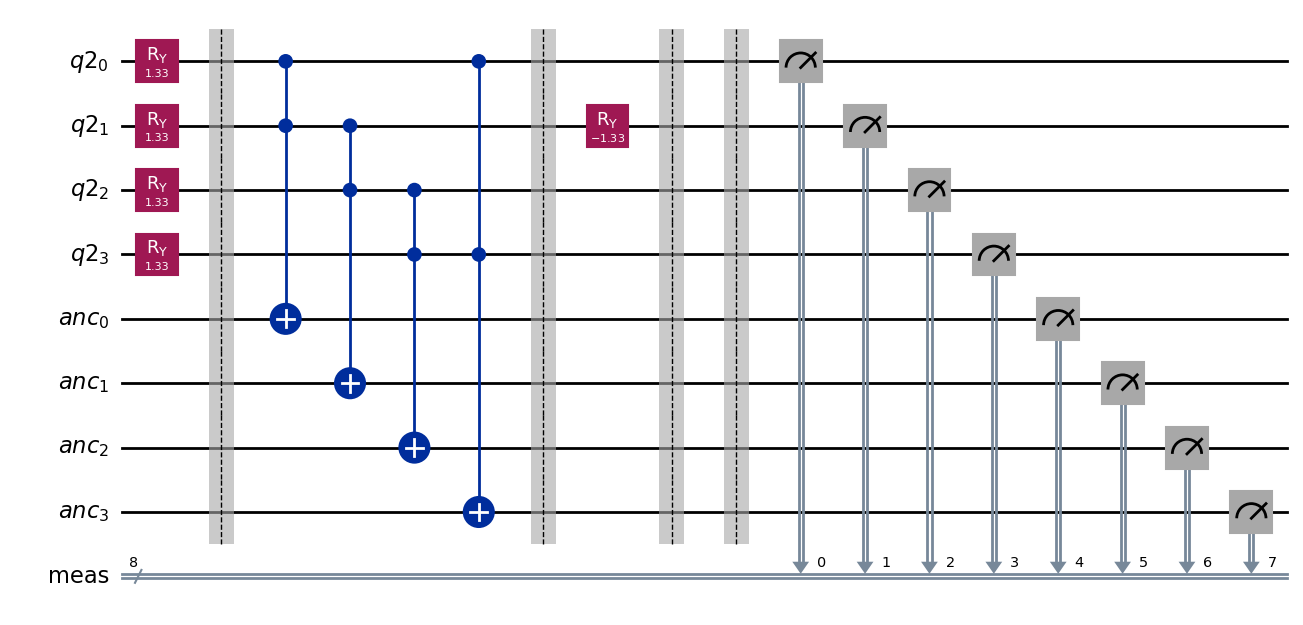

In [70]:
qc22 = second_condition_circuit(4,1,0.423*pi)
qc22.draw(output='mpl')

In [71]:
qc22_transpiled = transpile(qc22, backend=backend)

In [141]:
job22 = sampler.run([qc22_transpiled], shots=1024*2)
print(job22.job_id())

d08ahpykzhn000851w70


In [142]:
job_id = 'd08ahpykzhn000851w70'
job22 = service.job(job_id)

### b) Raw data

In [143]:
result22 = job22.result()
sampler_result22 = result22[0]
data22 = sampler_result22.data
counts22 = data22.meas.get_counts()

d = 0
for n in range (4):
    for k, v in list(counts22.items()):
        j = 0
        for p in range (1):
            if len(k) > 0 and k[0] == '1':
                d += v
                del counts22[k]
                break
            j+=1

    for k, v in list(counts22.items()):
        counts22[k[1:]] = counts22.pop(k)
        
counts22 = {state[::-1]: population for state, population in counts22.items()}

### c) Final result

In [109]:
df3 = pd.DataFrame(list(counts22.items()), columns=["States", "Counts"])
df3.to_excel("cond22_Brisbane_data.xlsx", index=False)

In [8]:
experiment22 = pd.read_excel("cond22_Brisbane_data.xlsx", dtype={"States": str})
counts22 = dict(zip(experiment22["States"], experiment22["Counts"]))

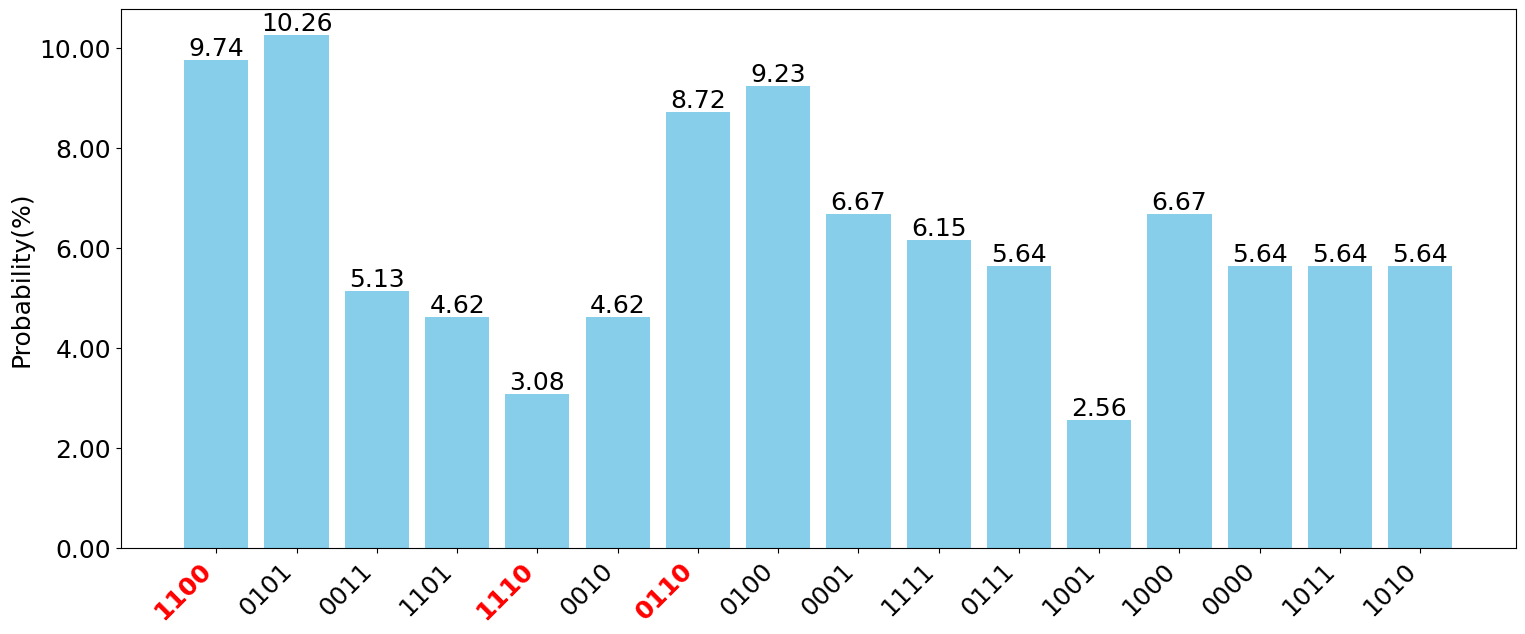

In [9]:
total_count = sum(counts22.values())

probabilities = {state: count / total_count for state, count in counts22.items()}

states = list(probabilities.keys())  
prob_values = list(probabilities.values())

plt.figure(figsize=(18, 7))
bars = plt.bar(states, prob_values, color='skyblue')

for bar, prob in zip(bars, prob_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{prob * 100:.2f}', ha='center', va='bottom', fontsize=18)

highlight_states = {'1100', '1110', '0110'}  
tick_labels = plt.gca().get_xticklabels()  
tick_labels_text = plt.gca().get_xticklabels() 
for label, state in zip(tick_labels_text, states):  
    if state in highlight_states:
        label.set_color('red')  
        label.set_fontweight('bold') 

def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability(%)", fontsize=18)

plt.show()

## 2.3. $R_y(-\theta)$ on the third qubit
### a) Quantum circuit

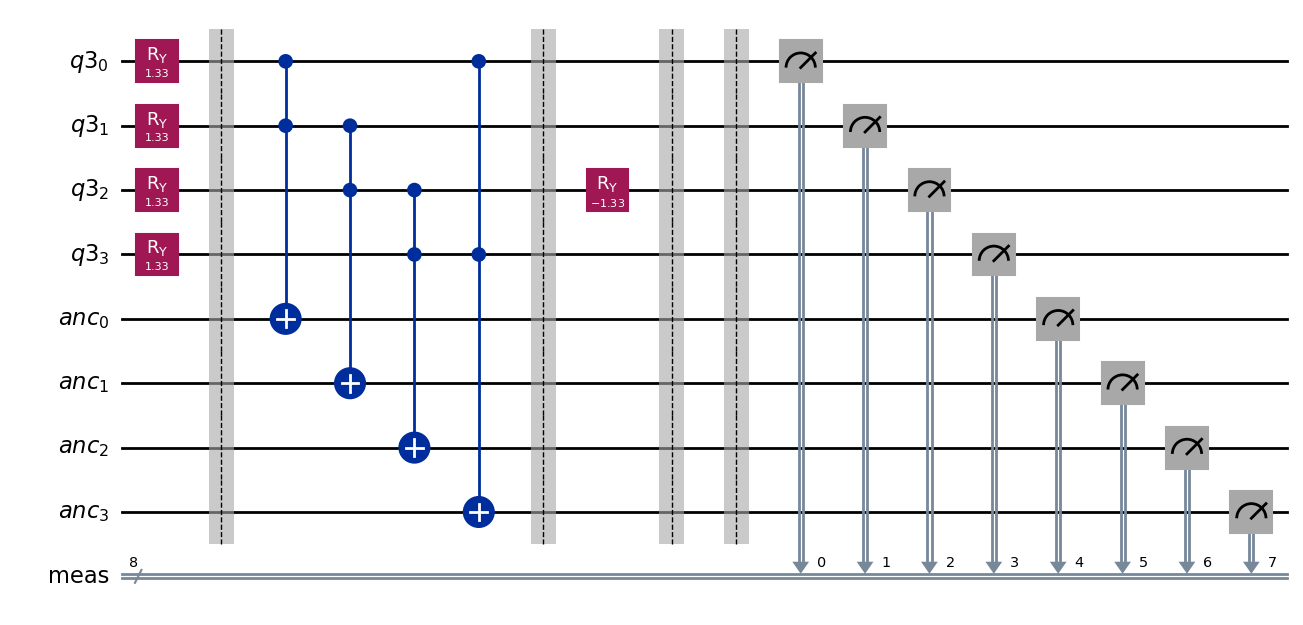

In [72]:
qc23 = second_condition_circuit(4,2,0.423*pi)
qc23.draw(output='mpl')

In [73]:
qc23_transpiled = transpile(qc23, backend=backend)

In [151]:
job23 = sampler.run([qc23_transpiled], shots=1024*2)
print(job23.job_id())

d08aq5mqnmvg0089jtm0


In [152]:
job_id = 'd08aq5mqnmvg0089jtm0'
job23 = service.job(job_id)

### b) Raw data

In [153]:
result23 = job23.result()
sampler_result23 = result23[0]
data23 = sampler_result23.data
counts23 = data23.meas.get_counts()

d = 0
for n in range (4):
    for k, v in list(counts23.items()):
        j = 0
        for p in range (1):
            if len(k) > 0 and k[0] == '1':
                d += v
                del counts23[k]
                break
            j+=1

    for k, v in list(counts23.items()):
        counts23[k[1:]] = counts23.pop(k)
        
counts23 = {state[::-1]: population for state, population in counts23.items()}

### c) Final result

In [119]:
df4 = pd.DataFrame(list(counts23.items()), columns=["States", "Counts"])
df4.to_excel("cond23_Brisbane_data.xlsx", index=False)

In [10]:
experiment23 = pd.read_excel("cond23_Brisbane_data.xlsx", dtype={"States": str})
counts23 = dict(zip(experiment23["States"], experiment23["Counts"]))

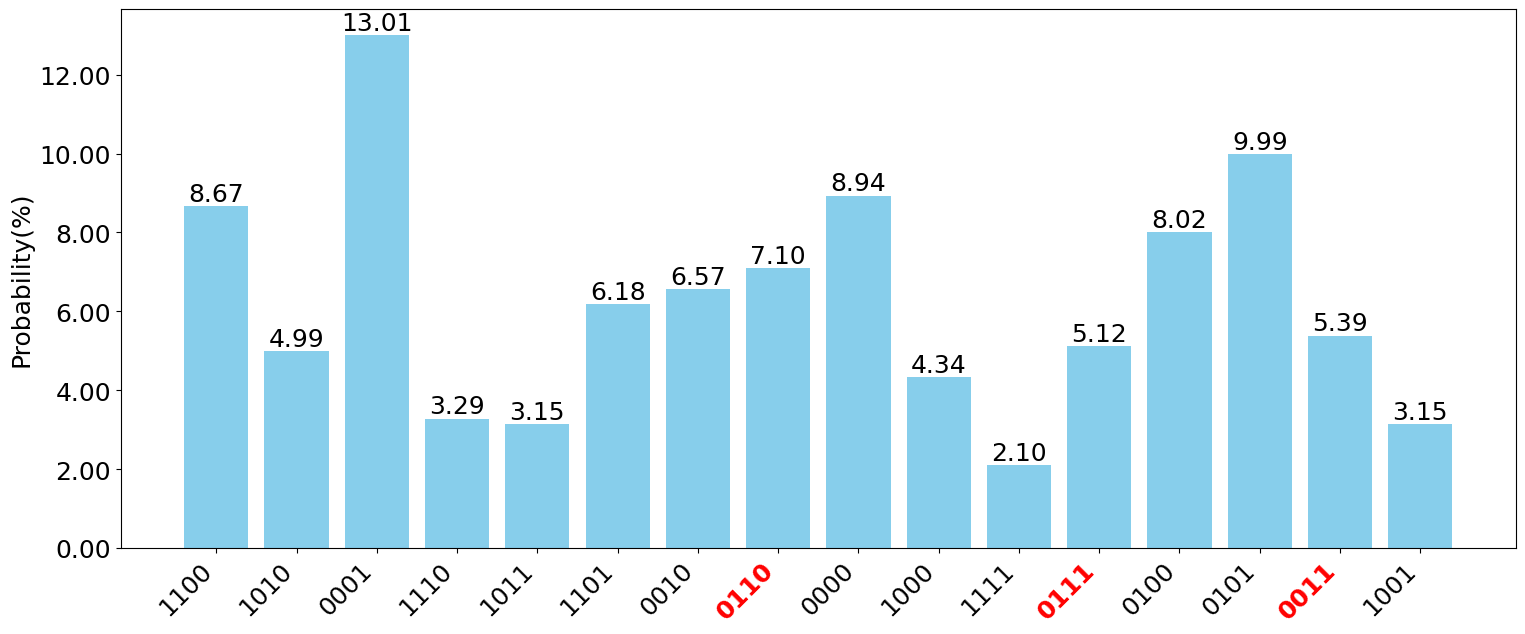

In [11]:
total_count = sum(counts23.values())

probabilities = {state: count / total_count for state, count in counts23.items()}

states = list(probabilities.keys())  
prob_values = list(probabilities.values())

plt.figure(figsize=(18, 7))
bars = plt.bar(states, prob_values, color='skyblue')

for bar, prob in zip(bars, prob_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{prob * 100:.2f}', ha='center', va='bottom', fontsize=18)

highlight_states = {'0110', '0011', '0111'}  
tick_labels = plt.gca().get_xticklabels()  
tick_labels_text = plt.gca().get_xticklabels() 
for label, state in zip(tick_labels_text, states):  
    if state in highlight_states:
        label.set_color('red')  
        label.set_fontweight('bold') 

def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability(%)", fontsize=18)

plt.show()

## 2.4. $R_y(-\theta)$ on the fourth qubit
### a) Quantum circuit

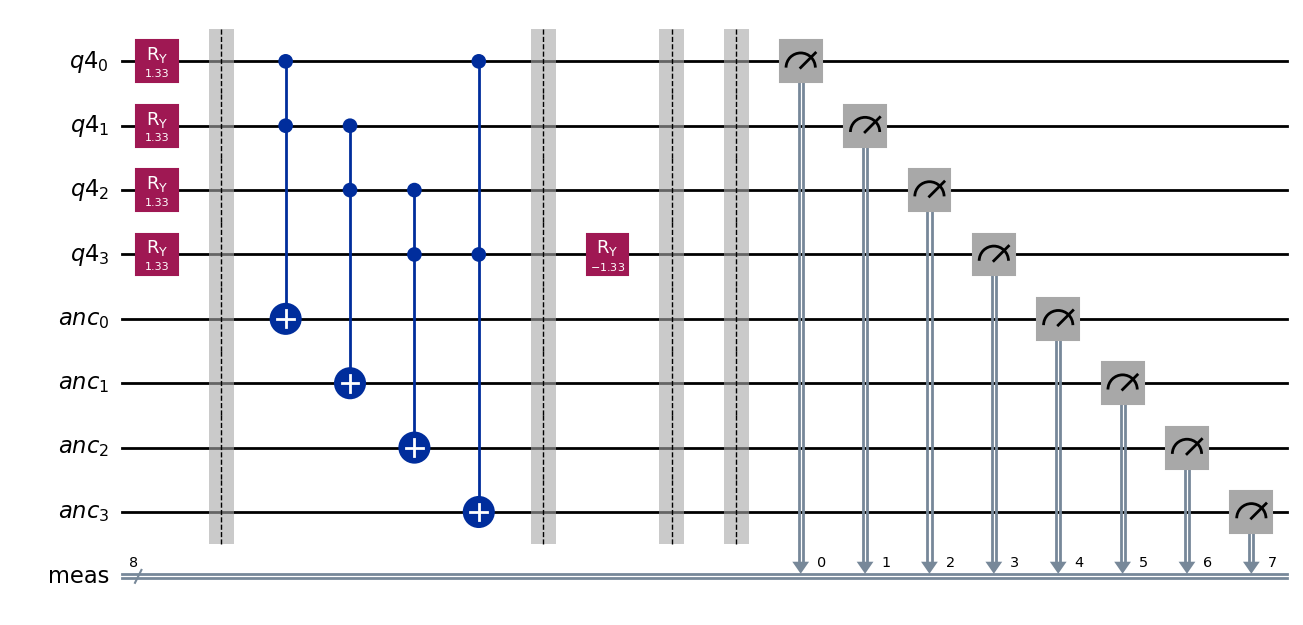

In [74]:
qc24 = second_condition_circuit(4,3,0.423*pi)
qc24.draw(output='mpl')

In [75]:
qc24_transpiled = transpile(qc24, backend=backend)

In [161]:
job24 = sampler.run([qc24_transpiled], shots=1024*4)
print(job24.job_id())

d08awgjd8drg0081fhrg


In [162]:
job_id = 'd08awgjd8drg0081fhrg'
job24 = service.job(job_id)

### b) Raw data

In [163]:
result24 = job24.result()
sampler_result24 = result24[0]
data24 = sampler_result24.data
counts24 = data24.meas.get_counts()

d = 0
for n in range (4):
    for k, v in list(counts24.items()):
        j = 0
        for p in range (1):
            if len(k) > 0 and k[0] == '1':
                d += v
                del counts24[k]
                break
            j+=1

    for k, v in list(counts24.items()):
        counts24[k[1:]] = counts24.pop(k)
        
counts24 = {state[::-1]: population for state, population in counts24.items()}

### c) Final result

In [125]:
df5 = pd.DataFrame(list(counts24.items()), columns=["States", "Counts"])
df5.to_excel("cond24_Brisbane_data.xlsx", index=False)

In [12]:
experiment24 = pd.read_excel("cond24_Brisbane_data.xlsx", dtype={"States": str})
counts24 = dict(zip(experiment24["States"], experiment24["Counts"]))

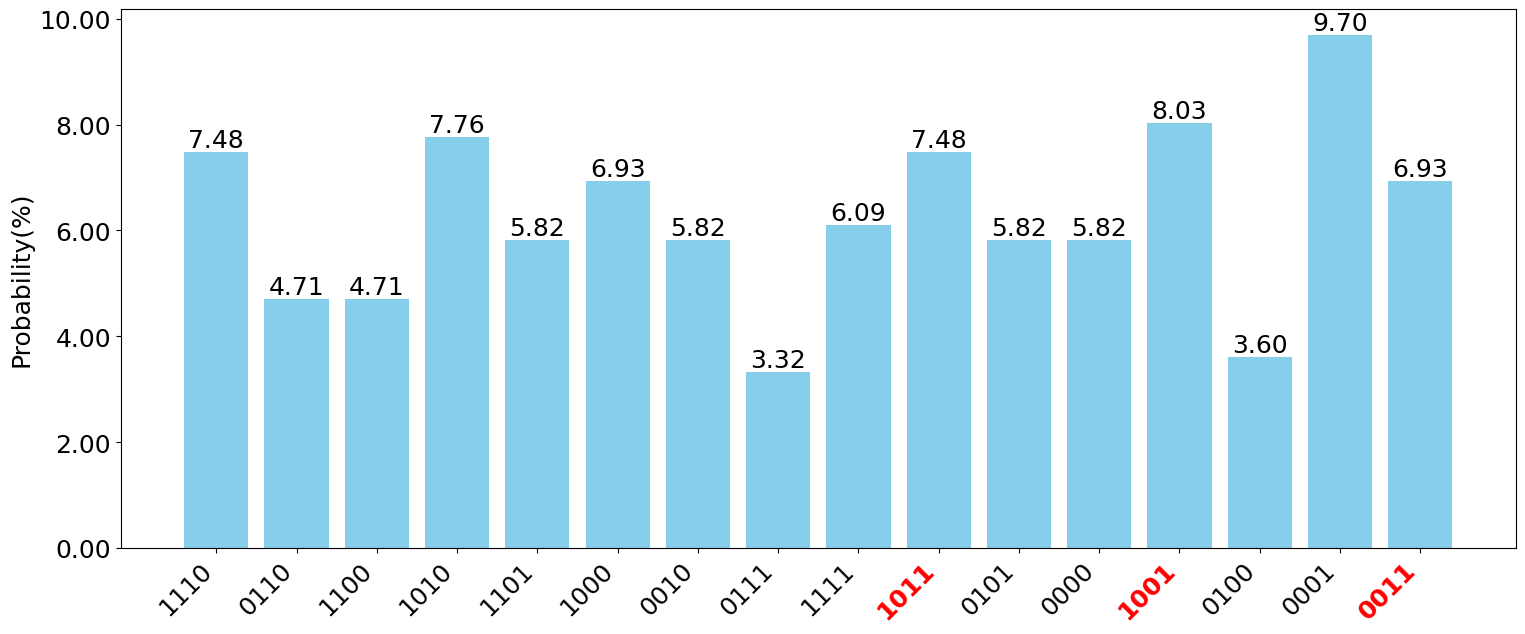

In [13]:
total_count = sum(counts24.values())

probabilities = {state: count / total_count for state, count in counts24.items()}

states = list(probabilities.keys())  
prob_values = list(probabilities.values())

plt.figure(figsize=(18, 7))
bars = plt.bar(states, prob_values, color='skyblue')

for bar, prob in zip(bars, prob_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
              f'{prob * 100:.2f}', ha='center', va='bottom', fontsize=18)

highlight_states = {'1001', '0011', '1011'}  
tick_labels = plt.gca().get_xticklabels()  
tick_labels_text = plt.gca().get_xticklabels() 
for label, state in zip(tick_labels_text, states):  
    if state in highlight_states:
        label.set_color('red')  
        label.set_fontweight('bold') 

def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability(%)", fontsize=18)

plt.show()

# 3. Third set of conditions
## a) Quantum circuit

In [77]:
def third_condition_circuit(num_qubit, theta):
    num_ancilla = num_qubit
    q = QuantumRegister(num_qubit)
    anc = QuantumRegister(num_ancilla, name="anc")
    #c = ClassicalRegister(num_qubit + num_ancilla, name="c")
    qc = QuantumCircuit(q,anc)
    
    for i in range (num_qubit):
        qc.ry(theta,i)
    
    qc.barrier()
    for i in range(num_qubit):
        if i == num_qubit-1:
            qc.ccx(q[i-3],q[i],anc[num_qubit-1])
        else:
            qc.ccx(q[i],q[i+1],anc[i])
    qc.barrier()
    for i in range (num_qubit):
        qc.ry(-theta,i)
    qc.barrier()
    qc.measure_all()
    
    return qc

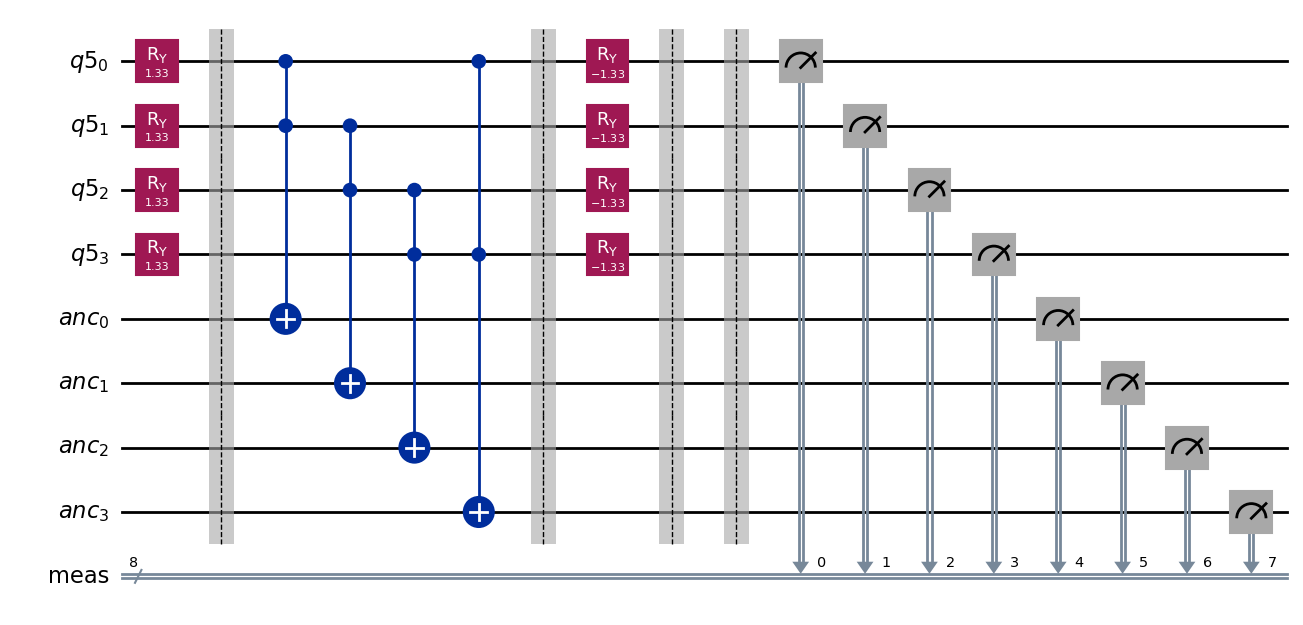

In [78]:
qc3 = third_condition_circuit(4,0.423*pi)
qc3.draw(output='mpl')

In [79]:
qc3_transpiled = transpile(qc3, backend=backend)

In [58]:
job3 = sampler.run([qc3_transpiled], shots=1024*2)
print(job3.job_id())

d051s7wnhqag008p407g


In [52]:
job_id = 'd051s7wnhqag008p407g'
job3 = service.job(job_id)

## b) Raw data

In [53]:
result3 = job3.result()
sampler_result3 = result3[0]
data3 = sampler_result3.data
counts3 = data3.meas.get_counts()

d = 0
for n in range (4):
    for k, v in list(counts3.items()):
        j = 0
        for p in range (1):
            if len(k) > 0 and k[0] == '1':
                d += v
                del counts3[k]
                break
            j+=1

    for k, v in list(counts3.items()):
        counts3[k[1:]] = counts3.pop(k)
        
counts3 = {state[::-1]: population for state, population in counts3.items()}

## c) Final result

In [131]:
df6 = pd.DataFrame(list(counts3.items()), columns=["States", "Counts"])
df6.to_excel("cond3_Brisbane_data.xlsx", index=False)

In [14]:
experiment3 = pd.read_excel("cond3_Brisbane_data.xlsx", dtype={"States": str})
counts3 = dict(zip(experiment3["States"], experiment3["Counts"]))

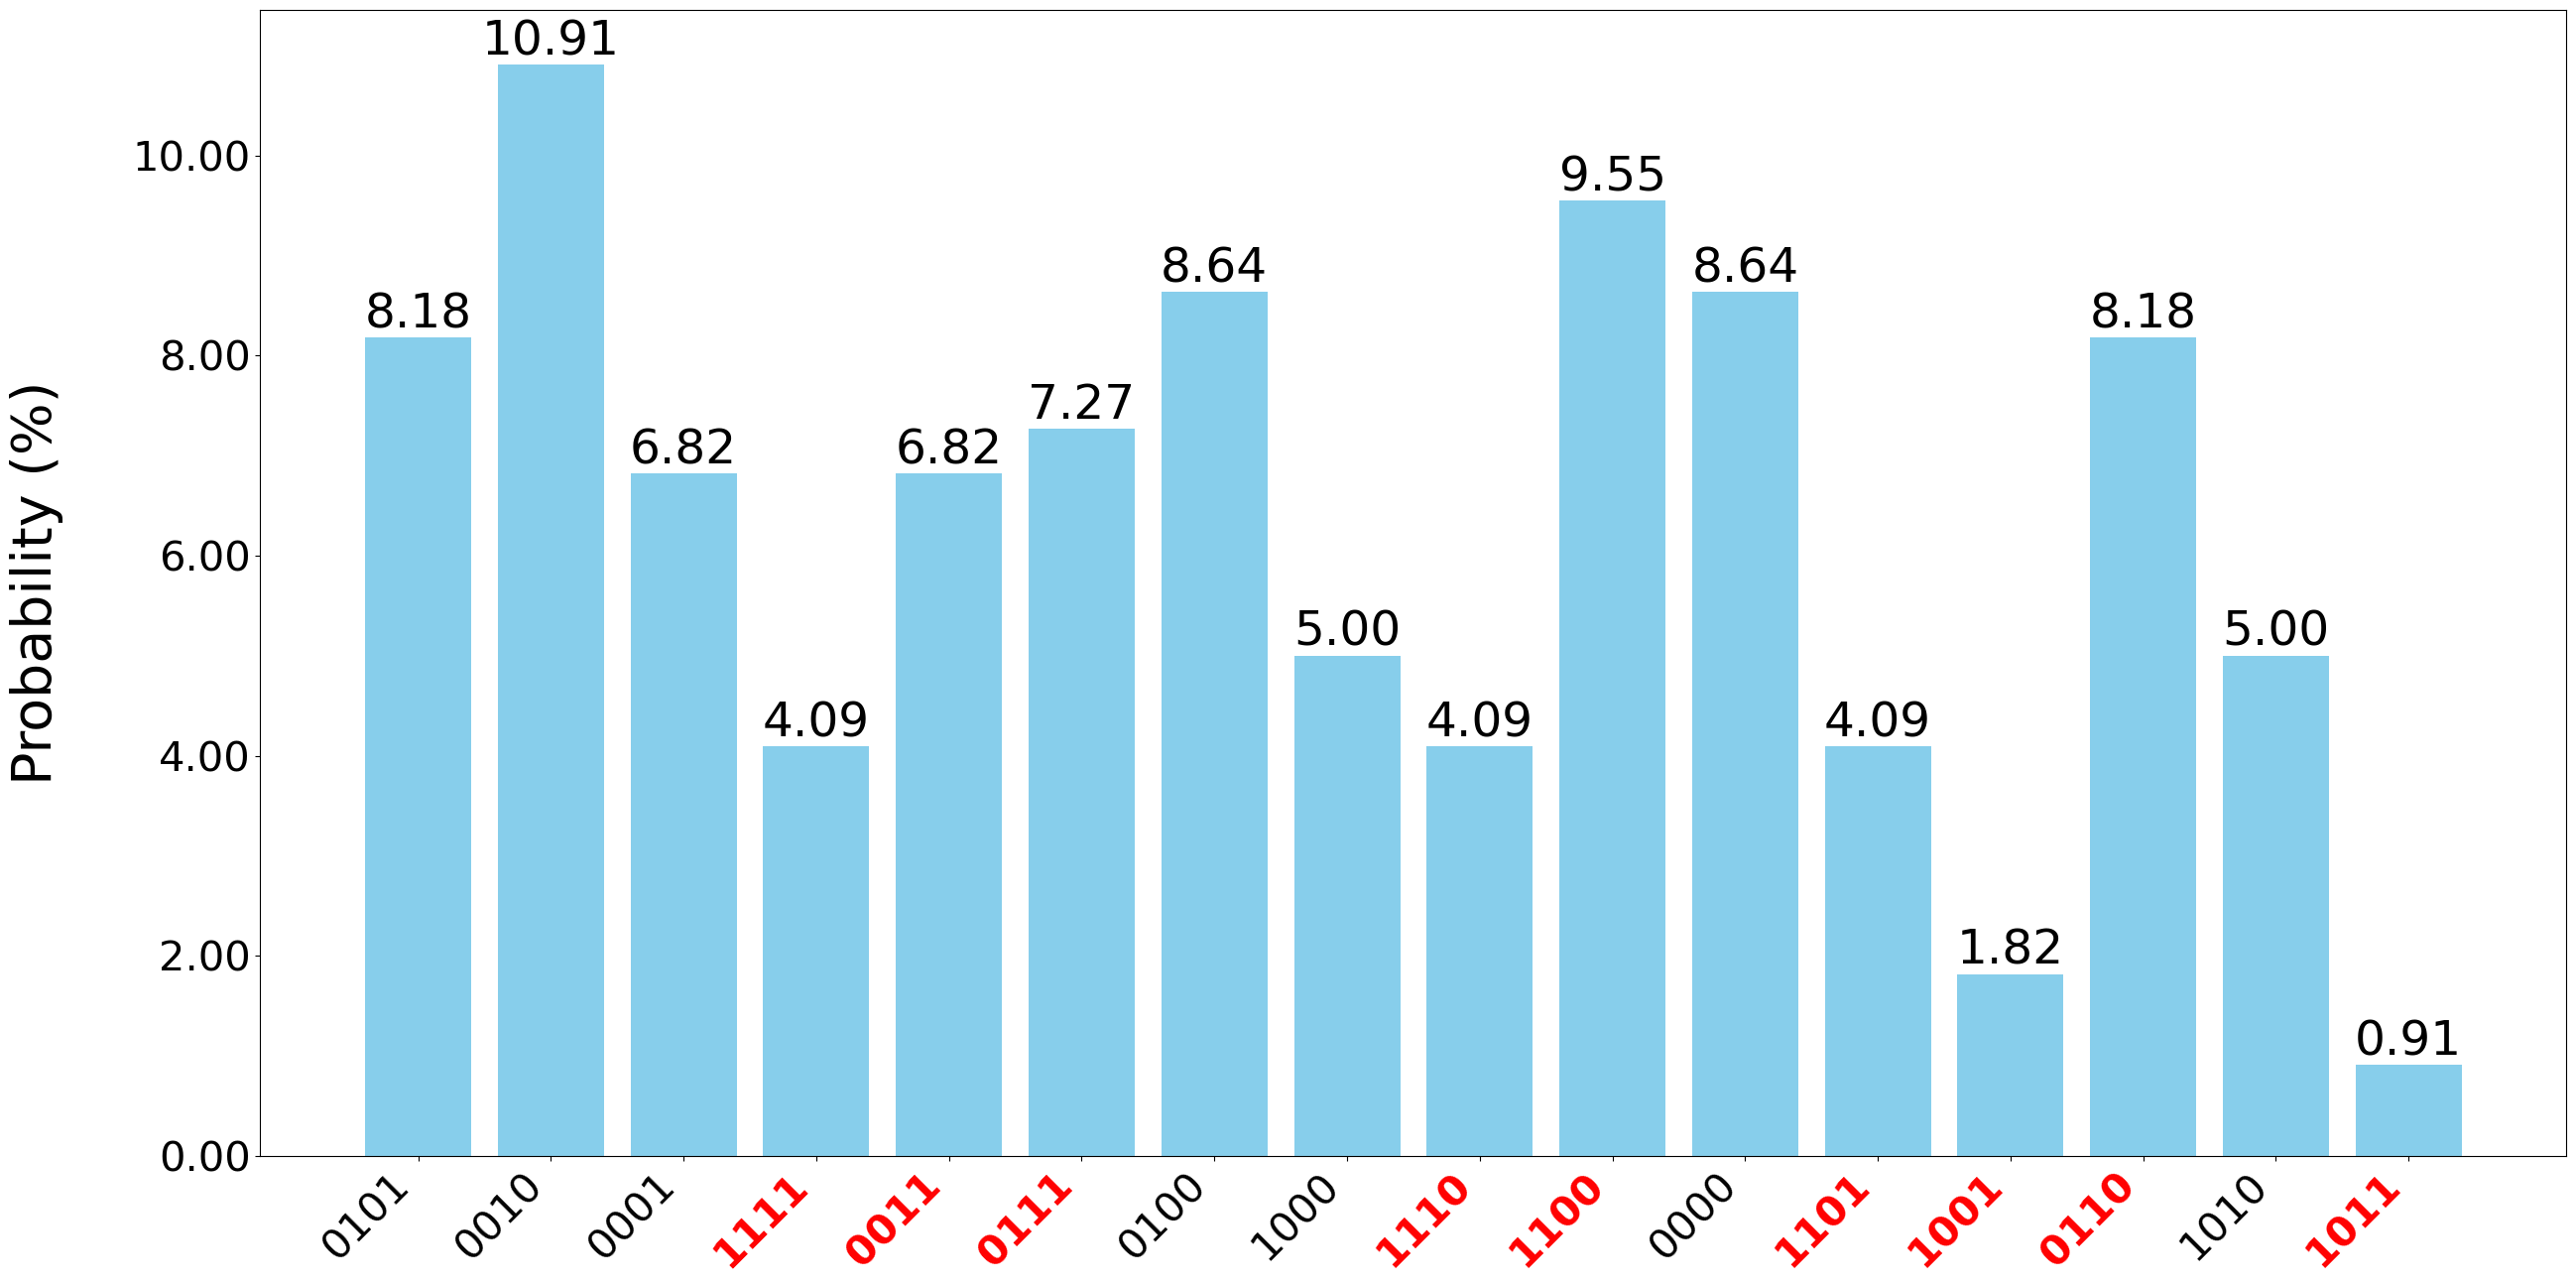

In [15]:
total_count = sum(counts3.values())

probabilities = {state: count / total_count for state, count in counts3.items()}

states = list(probabilities.keys())  
prob_values = list(probabilities.values())

plt.figure(figsize=(30,15))
bars = plt.bar(states, prob_values, color='skyblue', width=0.8)

for bar, prob in zip(bars, prob_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{prob * 100:.2f}', ha='center', va='bottom', fontsize=35)

highlight_states = {'1001', '0011', '1011', '1111', '1101', '1100', '0110', '1110', '0111'}  
tick_labels = plt.gca().get_xticklabels()  
tick_labels_text = plt.gca().get_xticklabels() 
for label, state in zip(tick_labels_text, states):  
    if state in highlight_states:
        label.set_color('red')  
        label.set_fontweight('bold') 

def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability (%)", fontsize=40, labelpad=50)

plt.show()